In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import math
import matplotlib.pyplot as plt

from pandas import get_dummies
from sklearn import preprocessing
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score


%matplotlib inline
plt.style.use('ggplot')

In [3]:
from Bio.SeqUtils import ProtParamData  # Local
from Bio.SeqUtils import IsoelectricPoint  # Local
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

## Feature engineering 
* Log50000
* chemical structure
* kidera factors
* Phylogenetic tree

In [4]:
"""
logarithming according to articles
"""
def log_meas(current):
    new_meas = 1 - math.log(current, 50000.0)
    if new_meas > 1: new_meas = 1
    if new_meas < 0: new_meas = 0
    return new_meas

In [5]:
"""
analyse_seq adds to DataFrame data with peptide sequences  columnns with chemical attributes of peptide
"""

def analyse_seq(sequences):
    physochem = pd.DataFrame()
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in sequences:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    physochem["molecular_weight"] = mol_weight
    physochem["aromaticity"] = aromaticity
    physochem["instability_index"] = instability_index
    physochem["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(physochem[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    physochem["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    physochem["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    physochem["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])
    return physochem

In [6]:
"""
to_one_hot function replaces "sequence" row in DataFrame data with OneHotEncoded sequences
"""
def to_one_hot(data, length):
    NMers = data[data["peptide_length"] == length].reset_index(drop=True)
    letters = NMers.sequence.apply(list) 
    #data_1Hot = pd.get_dummies(pd.DataFrame(list(letters)))
    #return pd.concat([NMers.drop(["sequence"], axis = 1), data_1Hot], axis = 1)
    return pd.get_dummies(pd.DataFrame(list(letters)))
    

In [7]:
"""
select_by_allele function returns DataFrame, which consists from data for one mhc by its allele
"""
def select_by_allele(data, allele):
    return data[data.mhc == allele].drop(["mhc"], axis = 1).reset_index(drop = True)

In [8]:
"""
add_kidera_ftr function returns DataFrame with kidera factors on column for a given peptide
"""
def add_kidera_ftr(peptides):
    kidera_peptides = pd.DataFrame()
    for i,fact in enumerate(f): 
        kidera_peptides[fact]=[add_kidera(j)[i] for j in peptides]
        #kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)
    return kidera_peptides

amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

def add_kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

## Dataset

In [9]:
Bdata = pd.read_csv("../mhc/bdata.csv")
Bdata.tail()
Bdata.meas = [log_meas(i) for i in Bdata.meas]

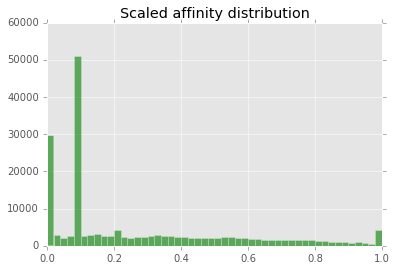

In [10]:
plt.title("Scaled affinity distribution")
hh = plt.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

## Sequence2Vector

In [11]:
# import modules & set up logging
import logging
import gensim
from gensim.models import word2vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 

In [12]:
def fill_spaces(seq):
    new_seq = list(seq)
    for i in range(1, len(seq)):
        new_seq[i] = " "+ new_seq[i]
    return ''.join(new_seq)

def seq2vec(seq):
    return w2v_model[list(seq)].flatten()

In [13]:
sequences = Bdata.sequence.apply(fill_spaces)

In [14]:
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 4          # Context window size                                                                                    
downsampling = 1e-3 
w2v_dim = 20

print("Training model...")
w2v_model = word2vec.Word2Vec(sequences, workers=num_workers, size = w2v_dim,
                              min_count = min_word_count, window = context, sample = downsampling)
print("Done.")

Training model...
Done.


In [15]:
#def get_knn_feature(data, target):
    

## Dataframes with 9mers peptides

In [71]:
peptides9mers = Bdata[Bdata.peptide_length == 9].sequence

#### 1. Sequence embedding

In [72]:
seq2vec9mers = pd.DataFrame(peptides9mers.apply(seq2vec)).reset_index(drop=True)
seq2vec9mers = pd.DataFrame(list(seq2vec9mers.sequence))
seq2vec9mers.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,0.501131,-0.361379,0.094884,0.056096,-0.506331,-0.064805,-0.082467,-0.127789,-0.209058,0.329936,...,-0.084847,0.276185,0.059875,0.365486,0.230107,0.311080,0.364282,-0.052159,0.386132,-0.577111
129809,0.153927,-0.394939,0.288109,-0.174673,-0.271127,0.144529,0.081196,0.194596,-0.336119,0.435722,...,-0.156846,0.410614,-0.061952,0.516606,0.606363,0.130370,0.182359,-0.009748,0.470326,-0.391805
129810,0.346659,-0.231408,0.468773,-0.076921,-0.540899,-0.096656,0.021586,-0.293807,-0.044309,0.233875,...,-0.500223,0.525895,-0.186645,0.381833,0.156774,0.470051,0.185351,-0.121841,0.568223,-0.415841
129811,0.355531,-0.239572,0.251852,0.352075,-0.455890,-0.181258,0.332529,0.082558,-0.402134,0.158948,...,-0.452852,0.196665,0.330324,0.535594,-0.013494,0.061202,-0.146912,0.006523,-0.039335,-0.328834
129812,0.384021,-0.185911,0.470247,0.045111,-0.427674,-0.176933,0.009702,0.128946,-0.557072,0.161070,...,-0.500223,0.525895,-0.186645,0.381833,0.156774,0.470051,0.185351,-0.121841,0.568223,-0.415841


#### 2.OneHotEncoding

In [17]:
OneHot9mers = to_one_hot(Bdata, 9)
OneHot9mers.tail()

,0_A,0_C,0_D,0_E,0_F,0_G,0_H,0_I,0_K,0_L,...,8_M,8_N,8_P,8_Q,8_R,8_S,8_T,8_V,8_W,8_Y
129808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129809,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
129810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129812,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3. Physochemical properties

In [73]:
PhChemicalData = analyse_seq(peptides9mers)
PhChemicalData.tail()

,molecular_weight,aromaticity,instability_index,isoelectric_point
129808,0.372089,0.000000,0.280008,0.050803
129809,0.323164,0.111111,0.293921,0.064873
129810,0.528654,0.333333,0.353245,0.085869
129811,0.488379,0.111111,0.220120,0.050803
129812,0.533740,0.555556,0.264814,0.246062


#### 4.Kidera factors

In [19]:
KideraData = add_kidera_ftr(peptides9mers)
KideraData.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
129808,-0.011111,-0.355556,-0.186667,0.011111,-0.106667,-0.116667,-0.481111,-0.560000,-0.167778,-0.061111
129809,0.172222,-0.478889,-0.176667,-0.304444,0.096667,-0.404444,-0.238889,-0.028889,-0.250000,0.283333
129810,0.367778,0.122222,0.144444,0.002222,-0.051111,-0.146667,-0.062222,0.642222,0.040000,-0.567778
129811,-0.387778,-0.070000,-0.372222,0.003333,0.041111,0.073333,-0.040000,0.148889,-0.108889,0.062222
129812,-0.450000,0.132222,0.138889,-0.887778,-0.113333,-0.695556,0.007778,0.648889,0.823333,-0.368889


#### 5.BLOSUM scoring matrix

In [98]:
blosum_matrix = pd.read_csv("../mhc/blosum.csv").drop(["x"], axis = 1)
def make_blosum(sequences):
    result = pd.DataFrame()
    for cur_seq in sequences:
        encoded = []
        for i, j in enumerate(list(cur_seq)):
            encoded.append(blosum_matrix[j][i])
        result = result.append(pd.Series(encoded), ignore_index = True)
    return result
        
blosum = make_blosum(peptides9mers)
blosum.head()

,0,1,2,3,4,5,6,7,8
0,4.0,-2.0,-3.0,-3.0,-3.0,0.0,-2.0,-2.0,-3.0
1,4.0,-2.0,-2.0,2.0,-3.0,1.0,-3.0,0.0,-3.0
2,4.0,-1.0,0.0,6.0,-3.0,-3.0,2.0,-2.0,-3.0
3,4.0,1.0,0.0,2.0,-1.0,-3.0,-3.0,-2.0,-3.0
4,-2.0,-1.0,0.0,-3.0,-3.0,-3.0,5.0,0.0,-3.0


## Training XGboost

In [61]:
def affinity_to_classes(affinity):
    return pd.Series([round(10*i, 0) for i in affinity])

def affinity_to_binary(affinity):
    return pd.Series(map(lambda x: 1 if x >= 0.5 else 0, affinity))

In [99]:
def xgb_grid_search(data, target):
    
    # split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    # train
    
    gbm_params = {
        'min_child_weight': [4, 7], 
        'gamma':[i/10.0 for i in range(0,5)]
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', max_depth = 7, max_delta_step = 5, learning_rate = 0.15, scale_pos_weight = 2), gbm_params, n_jobs=2, cv=5, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nACCURACY : %.4g\n==================" % metrics.roc_auc_score(y_test, predictions))
    

In [22]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
affinity_classes = affinity_to_classes(affinity)
affinity_binary = affinity_to_binary(affinity)

In [23]:
#xgb_grid_search(OneHot9mers, affinity_binary)

In [107]:
def xgb_best(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    gbm = xgb.XGBClassifier(objective='binary:logistic', max_depth = 7)
    gbm.fit(X_train, y_train)
    predictions = gbm.predict(X_test)
    print("Accuracy : %.4g" % metrics.roc_auc_score(y_test, predictions))
    
    

Best parameters:  {'learning_rate': 0.2, 'max_delta_step': 5, 'n_estimators': 250, 'max_depth': 7} 
Accuracy: 0.817

In [102]:
data_many_features = pd.concat([KideraData, PhChemicalData], axis=1)
dataframes = [KideraData, data_many_features]

xgb_grid_search(blosum, affinity_binary)
xgb_grid_search(pd.concat([blosum, OneHot9mers], axis=1), affinity_binary)

GridSeachCV proceeding...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.773264 -  14.2s
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.768038 -  14.5s


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   16.3s


[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.772225 -  14.1s
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.773367 -  14.7s
[CV] gamma=0.0, min_child_weight=7 ...................................


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   31.1s


[CV] .......... gamma=0.0, min_child_weight=4, score=0.772379 -  16.2s
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.767370 -  16.6s
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.773367 -  18.7s
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.774497 -  19.1s
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.768528 -  18.6s
[CV] gamma=0.1, min_child_weight=4 ...................................


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.4min


[CV] .......... gamma=0.0, min_child_weight=7, score=0.769452 -  18.1s
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.772288 -  16.4s
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.768346 -  17.1s
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.774189 -  15.3s
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.772996 -  16.0s
[CV] gamma=0.1, min_child_weight=7 ...................................


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.0min


[CV] .......... gamma=0.1, min_child_weight=4, score=0.769349 -  18.7s
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.768603 -  19.1s
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.772186 -  19.1s
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.772032 -  18.6s
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.772431 -  18.5s
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.771660 -  19.9s
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.770965 -  14.8s
[CV] gamma=0.2, min_child_weight=4 ...................................


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.2min


[CV] .......... gamma=0.2, min_child_weight=4, score=0.771672 -  16.1s
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.773470 -  19.9s
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.769298 -  20.5s
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.772893 -  15.4s
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.766651 -  15.0s
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.773521 -  20.8s
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.772956 -  21.4s
[CV] gamma=0.2, min_child_weight=7 ...................................


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.1min


[CV] .......... gamma=0.2, min_child_weight=7, score=0.771609 -  18.1s
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.772277 -  16.8s
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.771222 -  19.3s
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.771826 -  19.1s
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.773829 -  19.1s
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.769606 -  19.9s
[CV] gamma=0.3, min_child_weight=7 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.770171 -  18.8s
[CV] gamma=0.3, min_child_weight=7 ...................................
[CV] .

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.7min


[CV] .......... gamma=0.3, min_child_weight=7, score=0.773675 -  18.3s
[CV] gamma=0.3, min_child_weight=7 ...................................
[CV] .......... gamma=0.3, min_child_weight=7, score=0.772225 -  20.0s
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=7, score=0.770428 -  18.6s
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.771056 -  19.2s
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.769476 -  19.8s
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.773869 -  17.6s
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.775318 -  18.7s
[CV] gamma=0.4, min_child_weight=7 ...................................
[CV] .

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.0min


[CV] .......... gamma=0.4, min_child_weight=7, score=0.774959 -  18.4s
[CV] gamma=0.4, min_child_weight=7 ...................................
[CV] .......... gamma=0.4, min_child_weight=7, score=0.772751 -  19.2s
[CV] gamma=0.4, min_child_weight=7 ...................................
[CV] .......... gamma=0.4, min_child_weight=7, score=0.770274 -  20.5s
[CV] .......... gamma=0.4, min_child_weight=7, score=0.772636 -  19.7s


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  7.6min finished


Done.
BEST PARAMETERS:  {'gamma': 0.4, 'min_child_weight': 4} 

ACCURACY : 0.6122
GridSeachCV proceeding...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.786628 - 2.6min
[CV] .......... gamma=0.0, min_child_weight=4, score=0.790776 - 2.5min
[CV] gamma=0.0, min_child_weight=4 ...................................


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  2.7min


[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.793036 -  55.0s
[CV] gamma=0.0, min_child_weight=4 ...................................
[CV] .......... gamma=0.0, min_child_weight=4, score=0.793488 - 2.1min
[CV] gamma=0.0, min_child_weight=7 ...................................


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  5.4min


[CV] .......... gamma=0.0, min_child_weight=4, score=0.790304 - 2.2min
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.786063 - 2.1min
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.793088 - 2.1min
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.792420 - 2.2min
[CV] gamma=0.0, min_child_weight=7 ...................................
[CV] .......... gamma=0.0, min_child_weight=7, score=0.790458 - 2.1min
[CV] gamma=0.1, min_child_weight=4 ...................................


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 10.0min


[CV] .......... gamma=0.0, min_child_weight=7, score=0.789276 - 2.1min
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.787706 - 2.1min
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.789390 - 2.1min
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.794217 - 2.1min
[CV] gamma=0.1, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=4, score=0.790047 - 2.2min
[CV] gamma=0.1, min_child_weight=7 ...................................


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 16.1min


[CV] .......... gamma=0.1, min_child_weight=4, score=0.792152 - 2.2min
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.784471 - 2.2min
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.792060 - 2.2min
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.792471 - 2.2min
[CV] gamma=0.1, min_child_weight=7 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.790971 - 2.2min
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.1, min_child_weight=7, score=0.791331 - 2.2min
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.787347 - 2.2min
[CV] gamma=0.2, min_child_weight=4 ...................................


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 23.1min


[CV] .......... gamma=0.2, min_child_weight=4, score=0.789030 - 2.2min
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.790212 - 2.2min
[CV] gamma=0.2, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.791433 - 2.2min
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=4, score=0.790868 - 2.2min
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.783495 - 2.2min
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.791341 - 2.2min
[CV] gamma=0.2, min_child_weight=7 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.793909 - 2.1min
[CV] gamma=0.2, min_child_weight=7 ...................................


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 31.3min


[CV] .......... gamma=0.2, min_child_weight=7, score=0.789893 - 2.2min
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.2, min_child_weight=7, score=0.789430 - 2.2min
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.787706 - 2.2min
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.791855 - 2.2min
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.791033 - 2.2min
[CV] gamma=0.3, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.790920 - 2.2min
[CV] gamma=0.3, min_child_weight=7 ...................................
[CV] .......... gamma=0.3, min_child_weight=4, score=0.789944 - 2.2min
[CV] gamma=0.3, min_child_weight=7 ...................................
[CV] .

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 40.5min


[CV] .......... gamma=0.3, min_child_weight=7, score=0.795193 - 2.2min
[CV] gamma=0.3, min_child_weight=7 ...................................
[CV] .......... gamma=0.3, min_child_weight=7, score=0.791125 - 2.2min
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.3, min_child_weight=7, score=0.791844 - 2.2min
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.785549 - 2.2min
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.792163 - 2.2min
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.793344 - 2.2min
[CV] gamma=0.4, min_child_weight=4 ...................................
[CV] .......... gamma=0.4, min_child_weight=4, score=0.793488 - 2.2min
[CV] gamma=0.4, min_child_weight=7 ...................................
[CV] .

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 51.0min


[CV] .......... gamma=0.4, min_child_weight=7, score=0.789955 - 2.2min
[CV] gamma=0.4, min_child_weight=7 ...................................
[CV] .......... gamma=0.4, min_child_weight=7, score=0.792060 - 2.2min
[CV] gamma=0.4, min_child_weight=7 ...................................
[CV] .......... gamma=0.4, min_child_weight=7, score=0.790560 - 2.2min
[CV] .......... gamma=0.4, min_child_weight=7, score=0.787992 - 1.2min


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 54.4min finished


Done.
BEST PARAMETERS:  {'gamma': 0.4, 'min_child_weight': 4} 

ACCURACY : 0.6473


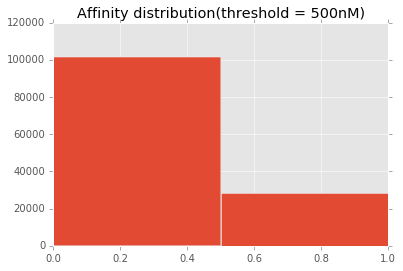

In [113]:
plt.title("Affinity distribution(threshold = 500nM)")
afd = affinity_binary.hist(bins=2)
